#方法:yoloでナンバープレート抽出したものをocrモデルに渡し結果を出す（ここではeasyocrライブラリーのモデルを使う）
##yoloはトレーニング回数が少ない以外は特に問題がないが時々easyocrが問題になる
##yoloの画像抽出とeasyocrのテキスト抽出を最後にクラスにした
##このコードは多少問題がある 車を一つだけの時コードが動作する。結果が間違いもある
##https://www.kaggle.com/code/myriamgam62/licence-plate-recognition-yolov8/notebook
##https://github.com/JaidedAI/EasyOCR

#ライブラリー、yoloモデルトレーニング、データ

In [ ]:
import re
import numpy as np
import pandas as pd
import os
from glob import glob
import xml.etree.ElementTree as xet

from google.colab.patches import cv2_imshow
import torch
import easyocr
import cv2
import matplotlib.pyplot as plt

In [ ]:
import locale

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip install easyocr

In [ ]:
def the_number_in_the_string(filename):
    match=re.search(('\d+'),filename)
    if match:
        return int(match.group(0))
    else:
        return 0
print(the_number_in_the_string("file123.txt"))
print(the_number_in_the_string("no_numbers"))

123
0


In [ ]:
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

In [ ]:

!kaggle datasets download -d andrewmvd/car-plate-detection

!unzip car-plate-detection.zip -d /content/car-plate-detection

dataset_path = '/content/car-plate-detection'

for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print('Data source import complete.')


In [ ]:
xml_files = glob(f'{dataset_path}/annotations/*.xml')
xml_files

In [ ]:
for filename in sorted(xml_files, key=the_number_in_the_string):

    info = xet.parse(filename)
    root = info.getroot()

    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

    alldata = pd.DataFrame(labels_dict)


In [ ]:
 alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/content/car-plate-detection/images/Cars0.png,226,419,125,173,500,268
1,/content/car-plate-detection/images/Cars1.png,134,262,128,160,400,248
2,/content/car-plate-detection/images/Cars2.png,229,270,176,193,400,400
3,/content/car-plate-detection/images/Cars3.png,142,261,128,157,400,225
4,/content/car-plate-detection/images/Cars4.png,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/content/car-plate-detection/images/Cars428.png,142,258,128,157,400,225
429,/content/car-plate-detection/images/Cars429.png,86,208,166,195,301,400
430,/content/car-plate-detection/images/Cars430.png,38,116,159,197,400,225
431,/content/car-plate-detection/images/Cars431.png,55,343,82,147,400,192


In [ ]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(alldata, test_size=1/10, random_state=42)
train, val = train_test_split(train, train_size=8/9, random_state=42)

In [ ]:
import shutil

if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [ ]:
def make_split_folder_in_yolo_format(split_name, split_df):
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')


    os.makedirs(labels_path)
    os.makedirs(images_path)


    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))


        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")


        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

In [ ]:
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


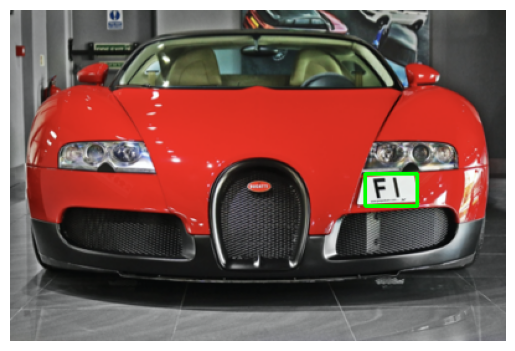

In [ ]:
image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

image_files = sorted(os.listdir(image_dir))
fifth_image_file = image_files[10]
image_path = os.path.join(image_dir, fifth_image_file)
label_path = os.path.join(label_dir, os.path.splitext(fifth_image_file)[0] + '.txt')

image = cv2.imread(image_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


with open(label_path, 'r') as f:
    lines = f.readlines()


for line in lines:

    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height


    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)


plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 20.0 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8s.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 112MB/s] 


In [ ]:
model.train(
    data='datasets.yaml',
    epochs=5,
    batch=16,
    device='cuda',
    imgsz=320,
    cache=True
)

In [ ]:
def predict_and_plot(path_test_car):

    results = model.predict(path_test_car, device='cpu')


    image = cv2.imread(path_test_car)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    for result in results:
        for box in result.boxes:

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)


    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
path_test_car=test.iloc[0].img_path

In [ ]:
path_test_car

'/content/car-plate-detection/images/Cars425.png'

In [ ]:
results = model.predict('/content/1.jpg', device='cpu')


image 1/1 /content/1.jpg: 320x320 1 license_plate, 157.8ms
Speed: 1.2ms preprocess, 157.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)


array([[[127, 110,  89],
        [116,  99,  78],
        [116,  99,  80],
        ...,
        [177, 161, 144],
        [169, 154, 135],
        [171, 156, 137]],

       [[120, 103,  82],
        [123, 106,  85],
        [129, 112,  93],
        ...,
        [160, 144, 127],
        [155, 140, 121],
        [155, 140, 121]],

       [[123, 106,  85],
        [128, 111,  90],
        [131, 114,  95],
        ...,
        [149, 133, 116],
        [150, 134, 117],
        [148, 132, 115]],

       ...,

       [[125, 116, 102],
        [123, 114, 100],
        [123, 114, 100],
        ...,
        [ 85,  76,  67],
        [ 90,  79,  71],
        [ 91,  80,  72]],

       [[127, 118, 104],
        [124, 115, 101],
        [122, 113,  99],
        ...,
        [ 91,  80,  72],
        [ 87,  76,  68],
        [ 89,  78,  70]],

       [[127, 118, 104],
        [124, 115, 101],
        [122, 113,  99],
        ...,
        [ 87,  76,  68],
        [ 87,  76,  68],
        [ 81,  70,  62]]], dtype=uint8)
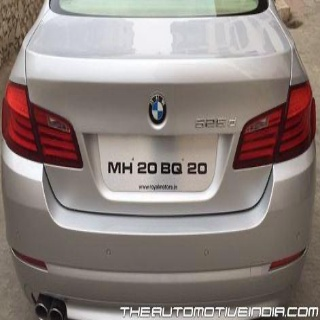

In [ ]:
results[0].orig_img

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
imges=[]
for result in results:
        for box in result.boxes:

            x1, y1, x2, y2 = map(int, box.xyxy[0])


            cropped_image = results[0].orig_img[y1:y2, x1:x2]
            imges.append(cropped_image)

array([[[150, 139, 131],
        [175, 164, 156],
        [168, 158, 148],
        ...,
        [152, 135, 116],
        [147, 130, 111],
        [152, 134, 117]],

       [[149, 140, 131],
        [174, 165, 156],
        [171, 162, 152],
        ...,
        [153, 133, 115],
        [148, 128, 110],
        [152, 134, 117]],

       [[148, 139, 130],
        [174, 165, 156],
        [175, 166, 157],
        ...,
        [154, 134, 117],
        [149, 129, 112],
        [153, 135, 118]],

       ...,

       [[137, 131, 124],
        [152, 146, 139],
        [182, 176, 171],
        ...,
        [242, 242, 242],
        [241, 242, 240],
        [237, 235, 234]],

       [[132, 126, 119],
        [142, 136, 129],
        [166, 160, 155],
        ...,
        [247, 245, 244],
        [240, 238, 237],
        [223, 219, 218]],

       [[130, 124, 119],
        [135, 129, 124],
        [151, 145, 140],
        ...,
        [245, 243, 242],
        [230, 226, 225],
        [198, 193, 190]]], dtype=uint8)
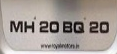

In [ ]:
imges[0]

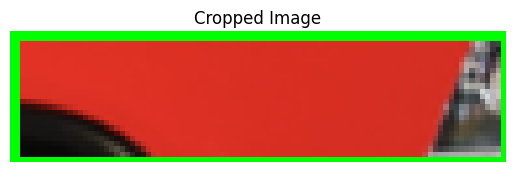

In [ ]:
plt.figure()
plt.imshow(cropped_image)
plt.axis('off')
plt.title('Cropped Image')
plt.show()

#ocrモデル、結果

In [ ]:
reader = easyocr.Reader(['en'])

In [ ]:
class Result:
    def __init__(self, model, reader):
        self.model = model
        self.reader = reader
        self.imges = []

    def extraction(self, image_path):
        results = self.model.predict(image_path, device='cpu')

        self.imges = []
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                cropped_image = results[0].orig_img[y1:y2, x1:x2]
                self.imges.append(cropped_image)
        return self.imges

    def recognize(self):
        if not self.imges:
            raise ValueError("No images found. Run extraction() first.")
        return self.reader.readtext(self.imges[0], detail=0)





In [ ]:
result = Result(model, reader)

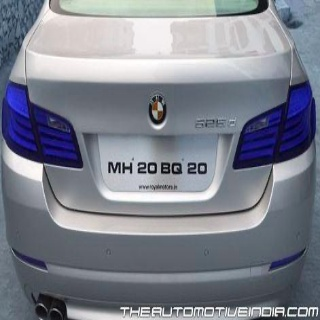

In [ ]:
image=cv2.imread('/content/1.jpg')
cv2_imshow(image)

In [ ]:
images = result.extraction('/content/1.jpg')
text = result.recognize()
print(text)


image 1/1 /content/1.jpg: 320x320 1 license_plate, 134.8ms
Speed: 1.3ms preprocess, 134.8ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)
['MH 2080 20']


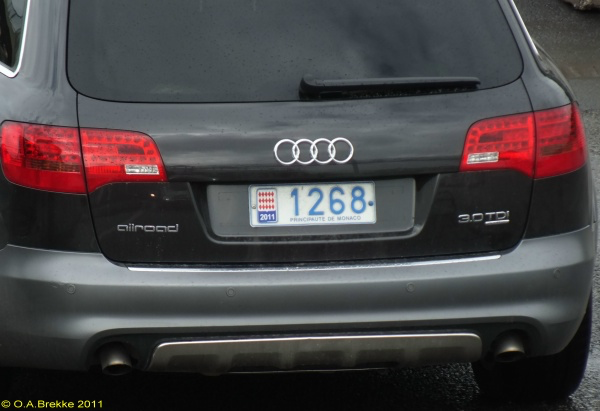


image 1/1 /content/car-plate-detection/images/Cars133.png: 224x320 1 license_plate, 126.1ms
Speed: 1.6ms preprocess, 126.1ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)
['1268']


In [ ]:
image2=cv2.imread('/content/car-plate-detection/images/Cars133.png')
cv2_imshow(image2)

images = result.extraction('/content/car-plate-detection/images/Cars133.png')
text = result.recognize()
print(text)

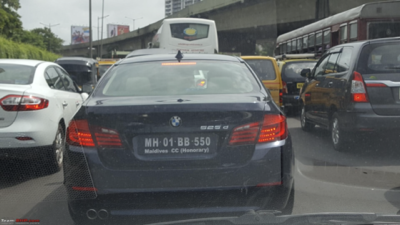


image 1/1 /content/car-plate-detection/images/Cars148.png: 192x320 1 license_plate, 99.0ms
Speed: 1.2ms preprocess, 99.0ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)
['MM 01288*551']


In [ ]:
image2=cv2.imread('/content/car-plate-detection/images/Cars148.png')
cv2_imshow(image2)

images = result.extraction('/content/car-plate-detection/images/Cars148.png')
text = result.recognize()
print(text)